[Topic Modeling 파이썬](https://wikidocs.net/76693)

[텍스트데이터 전처리](http://bigdata.emforce.co.kr/wp-content/uploads/%EC%97%A0%ED%8F%AC%EC%8A%A4-%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%9E%A9_%ED%86%A0%ED%94%BD%EB%AA%A8%EB%8D%B8%EB%A7%81LDA%EB%B0%A9%EB%B2%95%EB%A1%A0-%EC%A0%95%EB%A6%AC.pdf)

[gensim](https://joyhong.tistory.com/138)

[LDA 파라미터 튜닝](https://coredottoday.github.io/2018/09/17/%EB%AA%A8%EB%8D%B8-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0-%ED%8A%9C%EB%8B%9D/)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import re 
import time 
import datetime
import gensim # LDA 적용을 위한 텍스트의 벡터화
import pyLDAvis # LDA 토픽모델링 시각화 
import pyLDAvis.gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
from collections import Counter # 빈도수 계산
from string import punctuation # 구두점 제거 
from konlpy.tag import Kkma 

pd.set_option('display.max_rows', 3000)

__부산카페, 부산카페추천, 부산카페투어, 부산신상카페 data 합치기__ 

In [2]:
# 주의 : 엑셀파일에서 첫번째 열 삭제 후 진행 

busan_cafe_ig_df = pd.DataFrame([ ])

folder = '/home/jongkwan1/양수연/'
f_list = ['부산카페1000.xlsx', '부산카페추천1000.xlsx', '부산카페투어500.xlsx', '부산신상카페500.xlsx']
for fname in f_list:
    fpath = folder + fname
    temp = pd.read_excel(fpath, engine='openpyxl') # 서버에서 사용할 때 engine='openpyxl' 써야 열림. 
    busan_cafe_ig_df = busan_cafe_ig_df.append(temp)

busan_cafe_ig_df.columns = ['content', 'hashtag', 'date']

busan_cafe_ig_df.head(4)

,content,hashtag,date
0,3월 부산 핫한 전시회 리스트✅역대급 형형색색 전시회 다모임!!놀러가기 딱 좋은 날...,"['#부산전시회', '#부산여행', '#부산핫플', '#부산데이트', '#부산데이트...",2021-03-25
1,고로나가 지겨워 일본으로 해외여행을 다녀왔습니다.. 근데 이제 해운대에 있는..동해...,"['#상생라멘', '#상생라멘심야식당', '#부산카페', '#경이와부산', '#경이...",2021-03-25
2,벚꽃카페🌸작년부터 가고싶었는데 직장인은 벚꽃타이밍에 늘 슬퍼요😭마침 집근처에 벚꽃맛...,"['#카페이띠', '#벚꽃카페', '#부산벚꽃', '#부산벚꽃명소', '#부산카페'...",2021-03-25
3,새 신을 신고 ~👞🎩. 신발 크네.. 김태형처럼 잘 생겼다 ❤️🦕 My handso...,[],2021-03-25


In [3]:
busan_cafe_ig_df.shape

(3000, 3)

__중복 데이터 (같은 게시글) 제거__

In [4]:
busan_cafe_ig_df.drop_duplicates(subset = ['content'], inplace=True)

busan_cafe_ig_df.shape 

(2626, 3)

__hashtag 결측행 삭제__ (hashtag가 두번째 이하 댓글에 있었을 것으로 추정)

In [5]:
busan_cafe_ig_df = busan_cafe_ig_df[busan_cafe_ig_df.hashtag != '[]']

busan_cafe_ig_df.shape 

(2326, 3)

In [6]:
busan_cafe_ig_df.to_excel('/home/jongkwan1/양수연/부산카페 통합본 3000 최종.xlsx', index=False) # 엑셀파일로 저장

In [7]:
busan_cafe_ig_df

,content,hashtag,date
0,3월 부산 핫한 전시회 리스트✅역대급 형형색색 전시회 다모임!!놀러가기 딱 좋은 날...,"['#부산전시회', '#부산여행', '#부산핫플', '#부산데이트', '#부산데이트...",2021-03-25
1,고로나가 지겨워 일본으로 해외여행을 다녀왔습니다.. 근데 이제 해운대에 있는..동해...,"['#상생라멘', '#상생라멘심야식당', '#부산카페', '#경이와부산', '#경이...",2021-03-25
2,벚꽃카페🌸작년부터 가고싶었는데 직장인은 벚꽃타이밍에 늘 슬퍼요😭마침 집근처에 벚꽃맛...,"['#카페이띠', '#벚꽃카페', '#부산벚꽃', '#부산벚꽃명소', '#부산카페'...",2021-03-25
5,왜 아직 수요일이에요?#황실스탠다드 🙌 @sonsh1nne #창원카페 #진해카페 #...,"['#황실스탠다드', '#창원카페', '#진해카페', '#전포카페', '#광안리카페...",2021-03-24
6,오늘 햇살 💯 #하브커피 커피 @callmebybae #부산카페#카페투어#해운대카페...,"['#하브커피', '#부산카페', '#카페투어', '#해운대카페', '#해리단길',...",2021-03-25
7,떨어지기 전에 팝콘 감상💗 🌸 @aayouxg #부산카페 #부산맛집 #카페투어 #카...,"['#부산카페', '#부산맛집', '#카페투어', '#카페추천', '#가오픈', '...",2021-03-25
8,어느새 봄🌸 🌸 @jhyunaaaa #벚꽃 #벚꽃놀이 #봄 #대구카페 #대구가오픈카...,"['#벚꽃', '#벚꽃놀이', '#봄', '#대구카페', '#대구가오픈카페', '#...",2021-03-25
9,윤정씨 딸기 감사합니당 ♥️❤️⠀⠀⠀⠀⠀⠀⚜️양산 MBC 아카데미 뷰티 미용학원⚜️...,"['#메이크업', '#헤어', '#네일', '#피부', '#자격증', '#학원', ...",2021-03-26
10,THE MUI과하지 않은 v넥 mtm 💘세트로 착용하실 수 있어요 :) * @the...,"['#망원동카페', '#성수동카페', '#여자코디', '#수트세트', '#롱원피스'...",2021-03-26
11,책은 읽는게아니고 장식용품❗__#daily#selca#selfie#follow#li...,"['#daily', '#selca', '#selfie', '#follow', '#l...",2021-03-26


### 전처리

__전처리 기준 세우기__ 

1. 카페와 관련없는 게시글 제거 (행 삭제) - 주로 광고성 글일 확률 높음 
2. 카페와 관련없는 잡다한 해쉬태그 제거 (해당 해쉬태그 삭제) - 검색유입량을 늘리고자 쓸데없는 해쉬태그를 많이 다는 경우가 많음 

#### 카페와 관련없는 게시글 제거 

In [8]:
# "호빠", "호스트바", "호스트빠" 가 hashtag에 들어있는 글만 출력해서 보기 

busan_cafe_ig_호빠 = busan_cafe_ig_df.loc[busan_cafe_ig_df['hashtag'].str.contains('호빠|호스트바|호스트빠', na=False)] 
busan_cafe_ig_호빠

,content,hashtag,date
371,🌐 호빠정상영업중 🌐🎉바다 보면서 끝내주는 놈들과 🎉시간당 TC 3.5 (30분만노...,"['#부산호빠', '#광안리호빠', '#연산동호빠', '#여성전용', '#해운대호빠...",2021-03-25
382,🏖부산의 NO.1 !핫플레이스 호빠🏖🌊❤️부산 최고급 사이즈🙋🏻‍♂️🧡부산 어디든 ...,"['#부산호빠', '#부산호스트', '#부산호스트빠', '#부산호스트바', '#부산...",2021-03-25
409,🌐 호빠정상영업중 🌐🎉바다 보면서 끝내주는 놈들과 🎉시간당 TC 3.5 (30분만노...,"['#부산호빠', '#광안리호빠', '#연산동호빠', '#여성전용', '#해운대호빠...",2021-03-25
415,나이스하다 ★초대형 호스트 신세계 탄생★부산호스트바는 수빈에게 맡겨주세요예약 : 0...,"['#해운대', '#서면', '#부산호빠', '#해운대클럽', '#부산역', '#부...",2021-03-25
416,"안녕하세요~해운대호스트바 여성전용룸은수빈에게 맡겨주세요예약 : 0I,0,6,7,7,...","['#해운대', '#서면', '#서면호빠', '#biff', '#부산국제영화제', ...",2021-03-25
426,"안녕하세요~해운대호스트바 여성전용룸은수빈에게 맡겨주세요예약 : 0I,0,6,7,7,...","['#해운대', '#서면', '#부산여행', '#남포동맛집', '#송정카페', '#...",2021-03-25
440,"안녕하세요~해운대호스트바 여성전용룸은수빈에게 맡겨주세요예약 : 0I,0,6,7,7,...","['#해운대', '#서면', '#해운대호빠', '#해운대여성전용', '#덕천호스트'...",2021-03-25
444,🏖오늘 밤을 책임질 부산의 핫플레이스 호빠 H 🏖🌊❤️부산 최고 가게 매너 짱!🙋🏻...,"['#부산호빠', '#부산호스트', '#부산호스트빠', '#부산호스트바', '#부산...",2021-03-25
484,나이스하다 ★초대형 호스트 신세계 탄생★부산호스트바는 수빈에게 맡겨주세요예약 : 0...,"['#해운대', '#서면', '#부산여행', '#창원', '#동래', '#기장힐튼'...",2021-03-25
491,🏖부산의 NO.1 !핫플레이스 호빠🏖🌊❤️부산 최고급 사이즈🙋🏻‍♂️🧡부산 어디든 ...,"['#부산호빠', '#부산호스트', '#부산호스트빠', '#부산호스트바', '#부산...",2021-03-25


In [9]:
# "호빠", "호스트바", "호스트빠" 가 hashtag에 들어있는 글은 모두 삭제해줌 

drop = busan_cafe_ig_df['hashtag'].str.contains('호빠|호스트바|호스트빠')
busan_cafe_drop = busan_cafe_ig_df[~drop]

len(busan_cafe_drop)

2310

In [10]:
# 위와 동일한 방법으로 특정 키워드 제거 

busan_cafe_drop_눈썹 = busan_cafe_drop.loc[busan_cafe_drop['hashtag'].str.contains('눈썹|미용|관리', na=False)] 
busan_cafe_drop_눈썹

,content,hashtag,date
9,윤정씨 딸기 감사합니당 ♥️❤️⠀⠀⠀⠀⠀⠀⚜️양산 MBC 아카데미 뷰티 미용학원⚜️...,"['#메이크업', '#헤어', '#네일', '#피부', '#자격증', '#학원', ...",2021-03-26
13,성빈이 누나분 항상 감사합니다 ㅠㅠ ♥️⠀⠀⠀⠀⠀⠀⚜️양산 MBC 아카데미 뷰티 미...,"['#메이크업', '#헤어', '#네일', '#피부', '#자격증', '#학원', ...",2021-03-26
17,얼마전 뷰티@쿨 방송에서도 신소율씨가 소개한 #팜스테라비타 ! 저는 이미 3년 넘게...,"['#팜스테라비타', '#모로코', '#실크같은피붓결', '#팜스테라비ᄐ...",2021-03-26
48,누나 일어나😐 #포미#포메#포메라니안#일어나#강아지#강아지모델#곰돌이컷#강아지미용#...,"['#포미', '#포메', '#포메라니안', '#일어나', '#강아지', '#강아지...",2021-03-26
65,셋뚜셋뚜 @baba2145 THE BABA BEAUTY. 개인레슨 전...,"['#부산반영구수강', '#부산반영구학원', '#부산반영구눈썹', '#부산반영구잘하...",2021-03-26
67,"4월 등록 마감됐어요,1:1 개인 레슨입니다.5월 등록 모집 선착순 접수 시작합니다...","['#부산반영구수강', '#부산반영구학원', '#부산반영구눈썹', '#부산반영구잘하...",2021-03-26
69,하투 하투 @baba2145 THE BABA BEAUTY. 개인레슨 저...,"['#부산반영구수강', '#부산반영구학원', '#부산반영구눈썹', '#부산반영구잘하...",2021-03-26
161,#20210326..어제 낮 온도는 정말 봄과 여름 사이같았을만큼 따스했어요😊여기저...,"['#20210326..어제', '#디그니티연헤어부띠크', '#...",2021-03-26
261,고객님의 감사한 후기 💕저 같아도 고객님 미모라면 계속 거울만 볼거 같아요 ......,"['#다이어트식단', '#일상소통', '#달맞이길', '#ootd', '#daily...",2021-03-25
381,도깨비젤 시술~♡ 스와도 춍춍!!!#스와네일 #도깨비젤네일 #부산카페 #부산여행 #...,"['#스와네일', '#도깨비젤네일', '#부산카페', '#부산여행', '#부산네일'...",2021-03-25


In [11]:
drop = busan_cafe_drop['hashtag'].str.contains('눈썹|미용|관리')
busan_cafe_drop = busan_cafe_drop[~drop]

len(busan_cafe_drop)

2264

In [12]:
busan_cafe_drop_백일상 = busan_cafe_drop.loc[busan_cafe_drop['content'].str.contains('백일상|파티룸|라이크휩크림', na=False)] 
busan_cafe_drop_백일상

,content,hashtag,date
112,"like whipcream에서는 다양한 공간대여(브라이덜샤워 , 백일•돌상 , 베이...","['#라이크휩크림', '#likewhipcream', '#부산파티룸', '#부산파티...",2021-03-21
147,"like whipcream에서는 다양한 공간대여(브라이덜샤워 , 백일•돌상 , 베이...","['#라이크휩크림', '#likewhipcream', '#부산파티룸', '#부산파티...",2021-03-22
220,"치-즈라면 ! 10년이 지나도 너흰 내 웃음버튼, 딸랑이 챙겨와 🥲🧡.#은솔_부산#...","['#은솔_부산', '#브라이덜샤워', '#예신', '#러플테이블', '#부산브라이...",2021-03-23
221,날 위해준그녀들에게 감사를 - 💓.#은솔_부산#브라이덜샤워#예신#러플테이블#부산브라...,"['#은솔_부산', '#브라이덜샤워', '#예신', '#러플테이블', '#부산브라이...",2021-03-19
222,First Bridal shower 🌼.#은솔_부산#브라이덜샤워#예신#라이크휩크림#...,"['#은솔_부산', '#브라이덜샤워', '#예신', '#라이크휩크림', '#부산브라...",2021-03-15
313,"like whipcream에서는 다양한 공간대여(브라이덜샤워 , 베이비샤워 , 생일...","['#라이크휩크림', '#likewhipcream', '#부산파티룸', '#부산파티...",2020-09-29
315,후기 이벤트로 7벌 브라이덜샤워용 드레스 무료 대여 해드려요 :)like whipc...,"['#라이크휩크림', '#likewhipcream', '#부산파티룸', '#부산파티...",2020-09-29
316,푹신한 소파에 앉아서 은은한 조명등 이용해서 여유있게 독서하셔도 좋아요 :)like...,"['#라이크휩크림', '#likewhipcream', '#부산파티룸', '#부산파티...",2020-09-28
317,보시고 싶은 영화 보시면서 힐링하세요 :)like whipcream에서는 다양한 공...,"['#라이크휩크림', '#likewhipcream', '#부산파티룸', '#부산파티...",2020-09-28
318,가장 좋아하는 영화 이프온리 빔프로젝터로 보면서 힐링 😄like whipcream에...,"['#라이크휩크림', '#likewhipcream', '#부산파티룸', '#부산파티...",2020-09-28


In [13]:
drop = busan_cafe_drop['hashtag'].str.contains('백일상|파티룸|라이크휩크림')
busan_cafe_drop = busan_cafe_drop[~drop]

len(busan_cafe_drop)

2237

In [14]:
busan_cafe_drop_헬스 = busan_cafe_drop.loc[busan_cafe_drop['hashtag'].str.contains('헬스', na=False)] 
busan_cafe_drop_헬스

,content,hashtag,date
208,..아틸란티스 바이킹프레스아틸란티스 벨트스쿼트...주문완료!세계최고 명품 기구 아틸...,"['#골져스피트니스', '#부산헬스', '#부산pt', '#서면헬스', '#서면pt...",2021-03-26
213,💛💛💛💛 💛 @wony_1_ #일상 #소통 #인친 #팔로워 #선팔 #맞팔 #데일리 ...,"['#일상', '#소통', '#인친', '#팔로워', '#선팔', '#맞팔', '#...",2021-03-26
223,내 옆에 해파리 ✔️ @_boutiquebell_ #셀카#셀피#팔로우#...,"['#셀카', '#셀피', '#팔로우', '#맞팔', '#선팔', '#소통', '#...",2020-08-21
224,돌아서면 머리가 길어있네 ? 맘에 안들게 말이야 ✔️ @_boutiquebell_ ...,"['#셀카', '#셀피', '#팔로우', '#맞팔', '#선팔', '#소통', '#...",2020-03-24
227,존버가 승리하겟쥬?😞😭😭#가슴운동#전신샷#쫄티...#경북도청신도시#금빛휘트니스센터#...,"['#가슴운동', '#전신샷', '#쫄티...', '#경북도청신도시', '#금빛휘트...",2021-03-26
248,🕊 ✔️ @_boutiquebell_ #셀카#셀피#팔로우#맞팔#선팔#소통#일상#데일...,"['#셀카', '#셀피', '#팔로우', '#맞팔', '#선팔', '#소통', '#...",2021-01-25
249,오랜만에 귀걸이했더니 귀가 아팠어요 ✔️ @_boutiquebell_ #셀카#셀피#...,"['#셀카', '#셀피', '#팔로우', '#맞팔', '#선팔', '#소통', '#...",2021-01-20
250,온수풀 생각보다 더 따뜻 🌬 ✔️ @_boutiquebe...,"['#셀카', '#셀피', '#팔로우', '#맞팔', '#선팔', '#소통', '#...",2020-12-15
251,요즘 아침형인간 힛 🧸🎈 ✔️ @_boutiquebell_ #셀카#셀피#팔로우#맞팔...,"['#셀카', '#셀피', '#팔로우', '#맞팔', '#선팔', '#소통', '#...",2020-11-30
252,✔️ @_boutiquebell_ #셀카#셀피#팔로우#맞팔#선팔#소통#일상#데일리#...,"['#셀카', '#셀피', '#팔로우', '#맞팔', '#선팔', '#소통', '#...",2020-11-24


In [15]:
drop = busan_cafe_drop['hashtag'].str.contains('헬스')
busan_cafe_drop = busan_cafe_drop[~drop]

len(busan_cafe_drop)

2192

In [16]:
busan_cafe_drop_집꾸미기= busan_cafe_drop.loc[busan_cafe_drop['hashtag'].str.contains('집꾸미기', na=False)] 
busan_cafe_drop_집꾸미기

,content,hashtag,date
354,.북유럽만의 따뜻함과 아늑함이 느껴지는제품들을 소개하고 있습니다🤍전 제품 덴마크 직...,"['#북유럽커피', '#수입원두', '#필터커피', '#스페셜티커피', '#모닝커피...",2021-03-25
891,MOMENT MAISON⠀⠀다시가면 이빵저빵다 먹어볼랭 🐽 빵수니가 꿈 @j_hye...,"['#모먼트메종', '#부산카페', '#전포카페', '#서면카페', '#전포신상카페...",2021-03-23
899,무스타슈 볼드체어 도착!언박싱 영상 유투브에 담았어요✨ ✨ #코덕 #뷰티스타그램 #...,"['#코덕', '#뷰티스타그램', '#인생템', '#뷰티', '#뷰티유투버', '#...",2021-03-23
960,"-안녕하곰🧸❔나는 아기베어라곰❣️-손수건, 테이블매트, 행주등으로 활용도 만점인 마...","['#곰돌이손수건', '#거즈손수건', '#요루손수선', '#어린이집손수건', '#...",2021-03-23
995,"어느 공간이나 주인의 가치관과 세계관이 묻어난다.그렇듯, 내 삶도 선명해지길 다짐하...","['#사진', '#사진소통', '#소통', '#사진보정', '#mood', '#li...",2021-03-23
250,🤍주문건🤍소라캔들 🕯🕯🕯심플한 오브제 ..#러브썸팩토리 ❤️ @lovesome_fa...,"['#러브썸팩토리', '#소라캔들', '#오브제캔들', '#캔들', '#집꾸미기',...",2021-03-15
262,얼마 전 #붙박이소파 제작해드린 #기장카페 #기장신상카페 #연화리카페 #부산신상카페...,"['#붙박이소파', '#기장카페', '#기장신상카페', '#연화리카페', '#부산신...",2021-03-15


In [17]:
drop = busan_cafe_drop['hashtag'].str.contains('집꾸미기')
busan_cafe_drop = busan_cafe_drop[~drop]

len(busan_cafe_drop)

2185

In [18]:
busan_cafe_drop_라멘 = busan_cafe_drop.loc[busan_cafe_drop['hashtag'].str.contains('라멘', na=False)] 
busan_cafe_drop_라멘

,content,hashtag,date
1,고로나가 지겨워 일본으로 해외여행을 다녀왔습니다.. 근데 이제 해운대에 있는..동해...,"['#상생라멘', '#상생라멘심야식당', '#부산카페', '#경이와부산', '#경이...",2021-03-25
311,맛있네요 행복하게 🍜..이곳은 해운대 #우동시장 안에 있는 #상생라멘 이라는 라멘 ...,"['#우동시장', '#상생라멘', '#나겸_공유', '#해운대카페', '#해운대카페...",2021-03-25
315,코로나로 너무 답답해서 일본 왔어요해운대에 있는 일본이요...🥲 . @__19920...,"['#해운대맛집', '#우동시장', '#상생라멘', '#해운대라멘맛집', '#해운대...",2021-03-25


In [19]:
drop = busan_cafe_drop['hashtag'].str.contains('라멘')
busan_cafe_drop = busan_cafe_drop[~drop]

len(busan_cafe_drop)

2182

In [20]:
busan_cafe_drop_스토어팜 = busan_cafe_drop.loc[busan_cafe_drop['content'].str.contains('스토어팜|마켓|쇼핑몰|옷가게', na=False)] # hashtag보다 content(글)에서 검색했을 때 결과가 더 많을 것이라고 판단하였음. 
busan_cafe_drop_스토어팜

,content,hashtag,date
10,THE MUI과하지 않은 v넥 mtm 💘세트로 착용하실 수 있어요 :) * @the...,"['#망원동카페', '#성수동카페', '#여자코디', '#수트세트', '#롱원피스'...",2021-03-26
18,과하지 않은 v넥 mtm 💘세트로 착용하실 수 있어요 :) * @themui.seo...,"['#망원동카페', '#성수동카페', '#여자코디', '#수트세트', '#롱원피스'...",2021-03-26
22,광안리 산책겸 앉아서 지나가는 사람 구경하기 ㅎㅎ 💜가끔은 멍때리는 힐링 넘 좋아용...,"['#광안리카페', '#광안리유동커피', '#광안대교', '#부산카페', '#부산가...",2021-03-26
31,-잠시 후 11시오픈잊지않으셨죠😛♥️청량감이 느껴지는 원단으로 제작되서지금부터 여름...,"['#the황언니', '#더황언니', '#황언니메이드', '#체크슬랙스', '#데일...",2021-03-26
41,"트라이탄 #리유저블컵 473ml(블랙 , 화이트 , 옐로우) 재입고 완료 💛🖤🤍블랙...",['#리유저블컵'],2021-03-26
42,단가라 반팔 카라니트 업데이트 되었습니당💙 스토어로 구경오세욤!! #ootd#운동스...,"['#ootd', '#운동스타그램', '#인친', '#소통', '#좋아요', '#좋...",2021-03-26
76,얼굴살 좀 가져가 주세요••• ♡ @_xxvely #fff #f4f #follow ...,"['#fff', '#f4f', '#follow', '#instalike', '#in...",2021-03-23
131,- the best items🙏🏻-상의 : 프롬셔츠하의 : 슬릿슬랙스 -#여성복 #...,"['#여성복', '#여자쇼핑몰', '#오오티디', '#데일리룩', '#봄코디', '...",2021-03-26
136,굿모닝 !트위드자켓은 핑쿠도 있어요🌸오늘 택배 빨리 마감하고 벚꽃이랑 야외촬영하러 ...,"['#벚꽃', '#트위드자켓', '#벚꽃놀이', '#하객룩', '#하객패션', '#...",2021-03-26
165,𝐻𝓌𝒶𝓃𝑔𝓊𝓃𝓃𝒾 𝓂𝒶𝒹𝑒 ♥오늘 오전 11시드디어 기다리고 기다리던제작팬츠 3차 ...,"['#오전11시오픈', '#황언니메이드', '#더황언니', '#데일리', '#데일리...",2021-03-26


In [21]:
drop = busan_cafe_drop['content'].str.contains('스토어팜|마켓|쇼핑몰|옷가게')
busan_cafe_drop = busan_cafe_drop[~drop]

len(busan_cafe_drop)

2084

In [22]:
# "스토어팜", "마켓", "쇼핑몰"로도 걸러지지 않은 의류 판매 게시글들을 어떻게 구분해낼지 애매하였음 ... 일단 다음과 같이 진행.

busan_cafe_drop_옷 = busan_cafe_drop.loc[busan_cafe_drop['content'].str.contains('팬츠|바지|치마|셔츠|자켓|니트|원피스', na=False)] 
busan_cafe_drop_옷

,content,hashtag,date
38,Black Jacket . @the_roije #selife#selca#daily#...,"['#selife', '#selca', '#daily', '#dailylook', ...",2021-03-26
55,💙날씨가 넘쥬타 주말 비예보 🥲..#봄 #부산 #해운대 #광안리 #기장카페 #가로수...,"['#봄', '#부산', '#해운대', '#광안리', '#기장카페', '#가로수길'...",2021-03-26
59,"✔️기본 긴팔 면티셔츠color:화이트,크림,레몬,연보라,소라,그레이,검정베이직 라...","['#창원', '#마산', '#창동', '#현동', '#...",2021-03-26
60,여름까지 쭉 입기좋은 셔츠🤍 #데일리룩#창원카페#진해카페#부산카페#대구카페#울산카페...,"['#데일리룩', '#창원카페', '#진해카페', '#부산카페', '#대구카페', ...",2021-03-26
83,요거 진짜 예쁜데🥺실물 느낌이 너무 안담겨서 속상하다 증말!사진보다 영상이 예쁜 우...,"['#화이트셔츠', '#더블버튼', '#투웨이셔츠', '#하이퀄리티', '#고급의류...",2021-03-26
84,🤍💙..#newarrival #패션 #스타일 #디자인 #데일리 #데일리룩 #부산 #...,"['#newarrival', '#패션', '#스타일', '#디자인', '#데일리',...",2021-03-26
87,봄=핑크💓 #봄#봄신상#카페#3월#셀카#셀피#데일리#일상#데일리룩#오오티디#아웃핏#...,"['#봄', '#봄신상', '#카페', '#3월', '#셀카', '#셀피', '#데...",2021-03-26
171,안녕하세요💛✔️ 제이 트위드자켓 입고 안내 드립니다. 옐로우 컬러 주문량이 폭주했었...,['#할인이벤트'],2021-03-26
389,왱케 벌크업된거처럼 보이디🤭🤫 🤍 @bin.s2___ #셀피#셀카#일상#맞팔#좋아요...,"['#셀피', '#셀카', '#일상', '#맞팔', '#좋아요테러', '#첫줄', ...",2021-03-25
520,겨울에는 치마에 롱부츠신고여름에는 그냥 반바지나 치마 입으면되는데 요즘에 롱부츠는 ...,"['#TMI지만', '#살이쏙쏙빠지는중']",2021-03-25


In [23]:
drop = busan_cafe_drop['hashtag'].str.contains('팬츠|바지|치마|셔츠|자켓|니트')
busan_cafe_drop = busan_cafe_drop[~drop]

len(busan_cafe_drop)

2064

In [24]:
# 엑셀파일로 만들어 저장 
busan_cafe_drop.to_excel('/home/jongkwan1/양수연/부산카페 통합본 3000 전처리 1차 완료.xlsx', index=False)

__1차 전처리 후 데이터 확인__

기간 : 2020년 3월 17일 ~ 2021년 3월 26일 (데이터 수집일 : 2021년 3월 26일 오후)

총 데이터 개수 : 2,101개 게시글

사용한 해쉬태그 : #부산카페(총 2,667,347개), #부산카페추천(총 197,302개), #부산카페투어(총 111,985개), #부산신상카페(총 96,052개)

수집 기준 : 인기게시물(9개) + 최신게시물의 본문, 첫번째 댓글, 첫번째 댓글의 대댓글 혹은 두번째 댓글 수집

__빈도 수 높은 hashtag 살펴보기__

In [25]:
# [] 안 개별 hashtag 추출

tags_total = []

for tags in busan_cafe_drop['hashtag']:
    tags_list = tags[2:-2].split("', '")
    for tag in tags_list:
        tags_total.append(tag)
        
tags_total

['#부산전시회',
 '#부산여행',
 '#부산핫플',
 '#부산데이트',
 '#부산데이트코스',
 '#부산카페',
 '#부산시립미술관',
 '#부산현대미술관',
 '#을숙도',
 '#해운대',
 '#서면',
 '#카페이띠',
 '#벚꽃카페',
 '#부산벚꽃',
 '#부산벚꽃명소',
 '#부산카페',
 '#부산감성카페',
 '#부산벚꽃카페',
 '#카페추천',
 '#냉정카페',
 '#개금카페',
 '#사상카페',
 '#여행에미치다',
 '#오빠랑여행갈래',
 '#여행다녀왔습니다',
 '#동서대카페',
 '#벚꽃뷰',
 '#벚꽃여행',
 '#황실스탠다드',
 '#창원카페',
 '#진해카페',
 '#전포카페',
 '#광안리카페',
 '#서울카페',
 '#부산카페',
 '#대구카페',
 '#카페',
 '#카페투어',
 '#신상카페',
 '#가오픈카페',
 '#일상',
 '#데일리',
 '#카페스타그램',
 '#온더테이블',
 '#맞팔',
 '#좋아요',
 '#좋아요반사',
 '#팔로우',
 '#감성',
 '#cafetour',
 '#daily',
 '#dailylook',
 '#ootd',
 '#fff',
 '#f4f',
 '#l4l',
 '#like',
 '#cafe',
 '#하브커피',
 '#부산카페',
 '#카페투어',
 '#해운대카페',
 '#해리단길',
 '#해리단길카페',
 '#반려견동반카페',
 '#일상',
 '#데일리',
 '#데일리룩',
 '#오오티디',
 '#좋아요',
 '#좋아요반사',
 '#좋반',
 '#팔로우',
 '#소통',
 '#첫줄반사',
 '#셀카',
 '#셀스타그램',
 '#부산카페',
 '#부산맛집',
 '#카페투어',
 '#카페추천',
 '#가오픈',
 '#신상카페',
 '#해운대카페',
 '#부산신상카페',
 '#서면카페',
 '#광안리카페',
 '#전포카페',
 '#동래카페',
 '#온천천카페',
 '#온천천카페거리',
 '#뮤제카바농',
 '#가오픈카페',
 '#감성카페',
 '#일상',
 '#온더테이블',
 '#daily'

In [26]:
tag_counts = Counter(tags_total) # 빈도수 계산

tag_counts_df = pd.DataFrame(tag_counts.most_common(100)) # 상위 100위에 해당하는 hashtag만 보기 
tag_counts_df.columns = ['tags', 'counts'] # dataframe으로 정리해서 보기 

tag_counts_df 

# 쓸데없는 hashtag들의 삭제가 필요할 것으로 보임.  

,tags,counts
0,#부산카페,1354
1,#부산카페추천,975
2,#부산카페투어,545
3,#카페투어,519
4,#부산신상카페,499
5,#부산,457
6,#부산여행,385
7,#부산맛집,376
8,#카페스타그램,372
9,#서면카페,372


__hashtag 데이터를 게시글별로 리스트화__ 

[게시글1], [게시글2],…[게시글n] 형태의 데이터 구조

추후 topic modeling 시에 게시글 단위로 문서를 나누고 해당 문서의 의미를 찾아내기 위해 리스트로 분리해서 나눠줘야 하기 때문.

In [27]:
busan_cafe_drop_list = list(busan_cafe_drop.hashtag)
busan_cafe_drop_list[0:3]

["['#부산전시회', '#부산여행', '#부산핫플', '#부산데이트', '#부산데이트코스', '#부산카페', '#부산시립미술관', '#부산현대미술관', '#을숙도', '#해운대', '#서면']",
 "['#카페이띠', '#벚꽃카페', '#부산벚꽃', '#부산벚꽃명소', '#부산카페', '#부산감성카페', '#부산벚꽃카페', '#카페추천', '#냉정카페', '#개금카페', '#사상카페', '#여행에미치다', '#오빠랑여행갈래', '#여행다녀왔습니다', '#동서대카페', '#벚꽃뷰', '#벚꽃여행']",
 "['#황실스탠다드', '#창원카페', '#진해카페', '#전포카페', '#광안리카페', '#서울카페', '#부산카페', '#대구카페', '#카페', '#카페투어', '#신상카페', '#가오픈카페', '#일상', '#데일리', '#카페스타그램', '#온더테이블', '#맞팔', '#좋아요', '#좋아요반사', '#팔로우', '#감성', '#cafetour', '#daily', '#dailylook', '#ootd', '#fff', '#f4f', '#l4l', '#like', '#cafe']"]

__카페와 관련없고 분석에 의미없는 hashtag 제거__

In [28]:
# 앞서 1차적으로 진행한 행 삭제와는 다름. 게시글 자체를 삭제하는 것이 아니라 특정 hashtag만 선별하여 제거해주는 것. stopwords와 같은 기능

busan_cafe_final_1 = []

# 특정 hashtag들을 공백으로 바꿔라
for tag in range(len(busan_cafe_drop_list)) :
    busan_cafe_final_1.append(re.sub('#여행에미치다|#오빠랑여행갈래|#여행다녀왔습니다|#오늘의여행|#오여_부산|#여행에미치다|#부산숙소추천|#부산숙박추천|#광안리호텔|#해운대호텔', 
                                     ' ', 
                                     busan_cafe_drop_list[tag]))

In [29]:
busan_cafe_final_1[0:3]

# 세번째 껄 보면 정상적으로 잘 삭제된 것을 확인할 수 있음. 이 방법을 사용하여 나머지 필요없는 hashtag들을 제거.

["['#부산전시회', '#부산여행', '#부산핫플', '#부산데이트', '#부산데이트코스', '#부산카페', '#부산시립미술관', '#부산현대미술관', '#을숙도', '#해운대', '#서면']",
 "['#카페이띠', '#벚꽃카페', '#부산벚꽃', '#부산벚꽃명소', '#부산카페', '#부산감성카페', '#부산벚꽃카페', '#카페추천', '#냉정카페', '#개금카페', '#사상카페', ' ', ' ', ' ', '#동서대카페', '#벚꽃뷰', '#벚꽃여행']",
 "['#황실스탠다드', '#창원카페', '#진해카페', '#전포카페', '#광안리카페', '#서울카페', '#부산카페', '#대구카페', '#카페', '#카페투어', '#신상카페', '#가오픈카페', '#일상', '#데일리', '#카페스타그램', '#온더테이블', '#맞팔', '#좋아요', '#좋아요반사', '#팔로우', '#감성', '#cafetour', '#daily', '#dailylook', '#ootd', '#fff', '#f4f', '#l4l', '#like', '#cafe']"]

In [30]:
busan_cafe_final_2 = []

for tag in range(len(busan_cafe_final_1)) :
    busan_cafe_final_2.append(re.sub('#부산해산물맛집|#상생라멘|#상생라멘심야식당|#스탠다드푸들|#프리랜서모델|#프로필|#모델프로필|#대구스튜디오|#스튜디오촬영|#집꾸미기|#오늘의집|#르헤이지|#셀린느|#셀린느카바스백', 
                                     ' ', 
                                     busan_cafe_final_1[tag]))

In [31]:
busan_cafe_final_3 = []

for tag in range(len(busan_cafe_final_2)) :
    busan_cafe_final_3.append(re.sub('#헬스|#헬린이|#눈바디|#운동스타그램|#유지어터|#운동하는직장인|#운동하는여자|#육아|#육아소통|#부산맘소통|#초보맘|#부산맘|#북구맘|#경남맘|#육아맘|#초보맘|#딸맘|#아들맘|#서울맘|#창원맘|#울산맘|#부경맘|#양산맘|#진해맘|#금동맘|#거제맘|#부산강서맘|#맘스타그램|#부산맘스타', 
                                     ' ', 
                                     busan_cafe_final_2[tag]))

In [32]:
busan_cafe_final_4 = []

for tag in range(len(busan_cafe_final_3)) :
    busan_cafe_final_4.append(re.sub('#팔로우|#팔로워|#일상|#데일리|#선팔|#맞팔|#선팔하면맞팔|#오오티디|#첫줄반사|#얼스타그램|#셀스타그램|#셀피|#운동|#팔로미|#훈스타그램|#훈녀|#공감|#일상|#소통|#인친|#팔로우|#팔로잉|#선팔맞팔|#맞좋|#좋반|#좋아요|#인친|#좋아요반사|#맞팔환영|#맞팔해요|#첫줄|#좋아요테러|#좋아요그램|#먹팔|#좋아요반사|#일상공유|#셀카|#인친해요|#행복한요즘|#반사|#인스타|#인스타그램|#맞팔선팔|#선팔환영|#맞팔댓글|#좋반테러|#좋아요테러|#일상소통|#소통해요|#인친해요|#페친|#인기게시물|#최근게시물반사|#럽스타그램|#뷰티스타그램|#얼스타그램|#팔로우늘리기|#맞좋아요|#인친환영|#좋튀|#좋아요반사테러|#좋반테|#좋테|#셀카|#셀피|#셀기꾼|#첫줄반사|#좋아요100|#오늘의훈녀|#선팔하면맞팔가요', 
                                     ' ', 
                                     busan_cafe_final_3[tag]))

In [33]:
busan_cafe_final_5 = []

for tag in range(len(busan_cafe_final_4)) :
    busan_cafe_final_5.append(re.sub('#selfie|#daily|#dailylook|#ootd|#selca|#like|#selstagram|#instagood|#dailylike|#fff|#f4f|#follow|#mood|#fashion|#sections|#model|#salca|#photography|#flf|#l4l|#photographer|#photo|#instalike|#instafollow|#likeforlikeslikeforfollow|#likesforlike|#followforfollowback|#followｍe|#instaphoto|#instapic|#style|#instadaily|#likeforlikes|#interiordesign|#instamood|#fff|#flb|#l4l❤️|#likes|#likesforlikesback|#likeforlikes|#follow4like|#likeforfollow|#photooftheday|#outfit|#tbt|#selahgraphy|#flowers|#SELAHS|#lfl|#likeforlike', 
                                     ' ', 
                                     busan_cafe_final_4[tag]))

In [34]:
busan_cafe_final_6 = []

for tag in range(len(busan_cafe_final_5)) :
    busan_cafe_final_6.append(re.sub('#미니멀룩|#여자코디|#스토어팜|#블로그마켓|#데일리룩|#여자데일리룩|#반팔니트|#놈코어룩|#화이트팬츠|#화이트데님|#담수진주목걸이|#진주목걸이|#아웃핏|#데일리룩|#쇼핑몰|#오프숄더|#하객룩|#무료배송|#대구쇼핑몰|#오프숄더니트|#봄코디|#44부터77까지|#팬츠|#팬츠추천|#오오티디룩|#최애룩|#패션|#일상룩', 
                                     ' ', 
                                     busan_cafe_final_5[tag]))

In [35]:
busan_cafe_final_7 = []

for tag in range(len(busan_cafe_final_6)) :
    busan_cafe_final_7.append(re.sub('#마산신상카페|#창원카페|#마산카페|#대구카페|#광주카페|#경남대카페|#경남카페|#진주카페|#진해카페|#창원가오픈카페|#창원신상카페|#창원|#마산|#진해|#동성로|#경주가볼만한곳|#대릉원|#화랑의언덕|#경주여행|#경주|#경주핫플|#경주황리단길|#경주황리단길맛집|#경주디저트맛집|#경주데이트|#경주빵집|#경주월드|#경주맛집추천|#첨성대|#동궁과월지|#안압지|#대구맛집|#울산맛집|#울산카페|#경주맛집|#황리단길맛집|#경주카페|#황리단길카페|#양산카페|#서울카페|#양산|#광복동|#창원맛집|#상남동맛집|#합성동맛집|#마산맛집|#송정맛집|#연남동카페|#망원동카페|#성수동카페|#제주카페|#대구|#대구카페|#동성로|#광주|#연남동|#광주카페|#한남동카페|#충장로|#한남동|#동명동|#청담|#압구정|#신창동카페|#신창동커피|#카페드신창|#이태원|#인천|#여의도|#홍대|#강남역|#한강|#포항카페|#향화정|#삼덕동카페|#수원카페|#부평|#송리단길|#대전카페|#삼덕동|#홍대카페|#서울|#경기도|#제주도|#제주도카페', 
                                     ' ', 
                                     busan_cafe_final_6[tag]))

In [36]:
busan_cafe_final_7

["['#부산전시회', '#부산여행', '#부산핫플', '#부산데이트', '#부산데이트코스', '#부산카페', '#부산시립미술관', '#부산현대미술관', '#을숙도', '#해운대', '#서면']",
 "['#카페이띠', '#벚꽃카페', '#부산벚꽃', '#부산벚꽃명소', '#부산카페', '#부산감성카페', '#부산벚꽃카페', '#카페추천', '#냉정카페', '#개금카페', '#사상카페', ' ', ' ', ' ', '#동서대카페', '#벚꽃뷰', '#벚꽃여행']",
 "['#황실스탠다드', ' ', ' ', '#전포카페', '#광안리카페', ' ', '#부산카페', ' ', '#카페', '#카페투어', '#신상카페', '#가오픈카페', ' ', ' ', '#카페스타그램', '#온더테이블', ' ', ' ', ' 반사', ' ', '#감성', '#cafetour', ' ', ' look', ' ', ' ', ' ', ' ', ' ', '#cafe']",
 "['#하브커피', '#부산카페', '#카페투어', '#해운대카페', '#해리단길', '#해리단길카페', '#반려견동반카페', ' ', ' ', ' 룩', ' ', ' ', ' 반사', ' ', ' ', ' ', ' ', ' ', ' ']",
 "['#부산카페', '#부산맛집', '#카페투어', '#카페추천', '#가오픈', '#신상카페', '#해운대카페', '#부산신상카페', '#서면카페', '#광안리카페', '#전포카페', '#동래카페', '#온천천카페', '#온천천카페거리', '#뮤제카바농', '#가오픈카페', '#감성카페', ' ', '#온더테이블', ' ']",
 "['#벚꽃', '#벚꽃놀이', '#봄', ' ', ' 가오픈카페', ' 근교카페', ' 브런치카페', ' ', '#연희동카페', ' ', ' 카페', '#부산카페', ' ', ' ', ' 카페', '#전주카페', ' ', ' 카페', ' ', ' ', ' 룩', ' ', ' ', ' ', ' ', ' ', ' 반사']",
 "[' ', ' 

__구두점 ('#') 제거__ 

In [37]:
def strip_punctuation(s): 
    return ''.join(c for c in s if c not in punctuation) 

clean_hashtag = []
for sent in busan_cafe_final_7 :
    clean = strip_punctuation(sent) # ... ""  ?  ! () 등 특수문자 제거해줌
    clean_hashtag.append(clean)
    
clean_hashtag

['부산전시회 부산여행 부산핫플 부산데이트 부산데이트코스 부산카페 부산시립미술관 부산현대미술관 을숙도 해운대 서면',
 '카페이띠 벚꽃카페 부산벚꽃 부산벚꽃명소 부산카페 부산감성카페 부산벚꽃카페 카페추천 냉정카페 개금카페 사상카페       동서대카페 벚꽃뷰 벚꽃여행',
 '황실스탠다드     전포카페 광안리카페   부산카페   카페 카페투어 신상카페 가오픈카페     카페스타그램 온더테이블      반사   감성 cafetour    look           cafe',
 '하브커피 부산카페 카페투어 해운대카페 해리단길 해리단길카페 반려견동반카페      룩      반사            ',
 '부산카페 부산맛집 카페투어 카페추천 가오픈 신상카페 해운대카페 부산신상카페 서면카페 광안리카페 전포카페 동래카페 온천천카페 온천천카페거리 뮤제카바농 가오픈카페 감성카페   온더테이블  ',
 '벚꽃 벚꽃놀이 봄    가오픈카페  근교카페  브런치카페   연희동카페    카페 부산카페      카페 전주카페    카페      룩            반사',
 '         sforlike   date          소통          테러  사테러   부산카페   울산   김해 포항 서면전포카페거리 남포동 해운대 송정 기장',
 'j949 부산 부산카페 신상카페 디저트 디저트카페 갤러리카페 부산외대 부산대 금정구 금정구맛집 금정구카페 남산동 남산동맛집 남산동카페 선동카페 범어사카페 오륜대카페            forlikes cafe coffee dessert      ',
 '프로듀스썸띵굿 producesomethinggood 호주식카푸치노커피 플렛화이트 피콜로라떼 라떼 카푸치노 아메리카노 핸드드립 필터커피 로스팅 티 초콜렛 말차 바리스타 부산 한국 호주 카페 부산커피 부산카페 광안동 광안리카페 수영카페 수영구카페 커피맛집 coffee roasting',
 '조팝나무 벚꽃🌸 베들링턴테리어',
 '한국여행 유학 일상 여행

__한글과 알파벳 명사만 추출 (꼬꼬마 형태소분석기 사용)__

hashtag 특성상 별도로 tokenize 하지는 않았음.

In [38]:
kkma = Kkma() # KKma 실행을 위해서는 따로 다른 변수에 선언해야 함. 

In [39]:
# 한글/알파벳 명사 이외는 모두 공백 처리 

dataset = [ ]
for i in range(len(clean_hashtag)) :
    dataset.append(kkma.nouns(re.sub('[^가-힣a-zA-Z\s]', '', clean_hashtag[i]))) 
    
instagram_hashtag = dataset    

    
# 로직이 실행되는 시간 파악     

start = time.time()
sec = time.time() - start
times = str(datetime.timedelta(seconds=sec)).split(",")
times = times[0]
print(times)

0:00:00.000048


__gensim을 이용한 언어모델(Language Model) 생성__

In [40]:
# 문자열 길이가 1이 아닐 때 y를 x만큼 넣고, x를 instagram_hashtag에 리스트 하나씩 저장 
instagram_hashtag = [[y for y in x if not len(y)==1]
                    for x in instagram_hashtag]

# 데이터를 dictionary 형태로 명사 list 만들기 
dictionary = corpora.Dictionary(instagram_hashtag) 

# 출현빈도가 너무 적거나 높은 단어는 제거 
dictionary.filter_extremes(no_below=10, no_above=0.05) 

# 명사 형태로 말뭉치 만들기 
corpus = [dictionary.doc2bow(text) for text in instagram_hashtag]

### 토픽모델링 (LDA)

Topic Modeling 구현 방법은 여러가지임. 그 중 gensim을 이용한 LDA (Latent Dirichlet Allocation)를 사용하였음.

__최적 Topic 개수 산출__

In [41]:
# Coherence Model

coherence_values = []

for i in range(2,15) : 
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word = dictionary) # 파라미터는 기본으로 설정 
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=instagram_hashtag, dictionary=dictionary, topn=10)
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

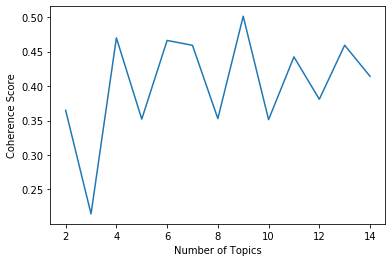

In [42]:
x = range(2,15)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

In [43]:
perplexity_values=[]

for i in range(2,20) : 
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary)
    perplexity_values.append(ldamodel.log_perplexity(corpus))

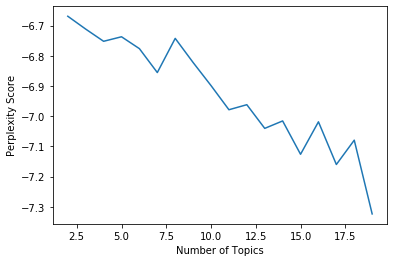

In [44]:
x = range(2,20)
plt.plot(x, perplexity_values)
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity Score")
plt.show()

__LDA 시각화__ (Topic 개수 9개일 때)

In [45]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=9, alpha=0.1, id2word=dictionary) # 위의 척도들을 참고하여 Topic 수를 9개로 지정.

In [46]:
ldamodel.print_topics(num_words=20)

[(0,
  '0.035*"마카롱" + 0.035*"동래카페" + 0.034*"동래" + 0.033*"마카롱맛집" + 0.032*"선물" + 0.018*"부산마카롱" + 0.018*"세트" + 0.016*"인생샷" + 0.016*"수제디저트" + 0.016*"인생" + 0.016*"수제" + 0.014*"빵순" + 0.014*"해운대맛집" + 0.012*"디저트맛집" + 0.012*"안락" + 0.011*"다대포" + 0.011*"단체" + 0.011*"명지" + 0.010*"답례" + 0.010*"파크"'),
 (1,
  '0.058*"가오픈카페" + 0.058*"감성카페" + 0.045*"카페인테리어" + 0.039*"인테리어" + 0.031*"핫플" + 0.029*"영도" + 0.028*"부산가오픈카페" + 0.028*"영도카페" + 0.025*"가오픈" + 0.025*"먼트" + 0.025*"모먼트메종" + 0.023*"홈카페" + 0.023*"아이" + 0.018*"부산대카페" + 0.018*"분위기" + 0.018*"카페그램" + 0.017*"부산맛" + 0.017*"아이폰" + 0.017*"나들이" + 0.017*"영도여행"'),
 (2,
  '0.038*"영도카페" + 0.037*"영도" + 0.030*"영도카페추천" + 0.027*"오션" + 0.027*"감성카페" + 0.026*"커피스타그램" + 0.025*"부산핫플레이스" + 0.025*"카페진목" + 0.025*"진목" + 0.025*"해운대핫플" + 0.025*"테러" + 0.020*"명지" + 0.020*"명지카페" + 0.019*"데이" + 0.018*"단체" + 0.017*"안락" + 0.017*"드라이브" + 0.013*"길맛집" + 0.013*"가능" + 0.013*"바닐라"'),
 (3,
  '0.036*"전포핫플" + 0.033*"대신" + 0.033*"블루" + 0.033*"기장신상카페" + 0.033*"해운" + 0.032*"서면브런" + 0.029*"먼트" + 0.02

In [47]:
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.130192 -0.009830       1        1  20.488367
3     -0.099116 -0.091610       2        1  13.201830
2     -0.013107  0.023211       3        1  11.331639
1     -0.154574  0.141041       4        1  11.322004
5      0.237492  0.184258       5        1  10.621972
8     -0.087100  0.039030       6        1   9.547565
7     -0.172798  0.027761       7        1   8.295362
4      0.142448 -0.127578       8        1   8.008835
6      0.016561 -0.186283       9        1   7.182429, topic_info=         Term        Freq       Total Category  logprob  loglift
553        명장  102.000000  102.000000  Default  30.0000  30.0000
117        주문  110.000000  110.000000  Default  29.0000  29.0000
54      마카롱맛집  149.000000  149.000000  Default  28.0000  28.0000
20       감성카페  165.000000  165.000000  Default  27.0000  27.0000
137    전포신상카페  167.000000  167.000000  Default  26.0000  26.0000
15      가오픈카페  119.000000  119.000000  Default  25.0000  25.0000
53        마카롱  161.000000  161.000000  Default  24.0000  24.0000
202       스퀘어   78.000000   78.000000  Default  23.0000  23.0000
203        피크   73.000000   73.000000  Default  22.0000  22.0000
204     피크스퀘어   72.000000   72.000000  Default  21.0000  21.0000
319        주말   89.000000   89.000000  Default  20.0000  20.0000
22       동래카페  191.000000  191.000000  Default  19.0000  19.0000
322   부산가오픈카페  129.000000  129.000000  Default  18.0000  18.0000
80       영도카페  123.000000  123.000000  Default  17.0000  17.0000
21         동래  197.000000  197.000000  Default  16.0000  16.0000
135    카페인테리어   89.000000   89.000000  Default  15.0000  15.0000
78         영도  127.000000  127.000000  Default  14.0000  14.0000
136        해운   66.000000   66.000000  Default  13.0000  13.0000
96         블루  126.000000  126.000000  Default  12.0000  12.0000
282    기장신상카페   66.000000   66.000000  Default  11.0000  11.0000
201      전포핫플   97.000000   97.000000  Default  10.0000  10.0000
102      서면브런   65.000000   65.000000  Default   9.0000   9.0000
366        먼트  124.000000  124.000000  Default   8.0000   8.0000
237        낭시   84.000000   84.000000  Default   7.0000   7.0000
67       인테리어   85.000000   85.000000  Default   6.0000   6.0000
550    동래신상카페   51.000000   51.000000  Default   5.0000   5.0000
552      라잇미업   51.000000   51.000000  Default   4.0000   4.0000
554       명장동   51.000000   51.000000  Default   3.0000   3.0000
556     명장동카페   51.000000   51.000000  Default   2.0000   2.0000
555     명장동맛집   51.000000   51.000000  Default   1.0000   1.0000
328       인생샷   48.459412   50.393147   Topic1  -4.1108   1.5462
55      부산마카롱   52.957142   55.591251   Topic1  -4.0221   1.5368
87      수제디저트   48.245922   51.098316   Topic1  -4.1152   1.5279
156        세트   51.795673   55.911503   Topic1  -4.0442   1.5088
85         선물   93.858742  108.120872   Topic1  -3.4498   1.4439
426        빵순   42.435471   49.434010   Topic1  -4.2436   1.4327
341       다대포   32.356033   42.872437   Topic1  -4.5147   1.3039
86         수제   45.956287   61.325001   Topic1  -4.1639   1.2968
460        음식    5.061255    6.767591   Topic1  -6.3699   1.2948
23         온천   25.305603   34.051109   Topic1  -4.7605   1.2885
289       먹스타    8.016677   11.144710   Topic1  -5.9100   1.2559
430     안락동카페   28.021156   40.334900   Topic1  -4.6586   1.2211
57         장산    4.417625    6.362137   Topic1  -6.5059   1.2206
524      초량카페    5.017995    7.227695   Topic1  -6.3785   1.2204
327        인생   46.385590   66.946495   Topic1  -4.1546   1.2184
83         사하    6.217566    8.986471   Topic1  -6.1642   1.2170
84        사하구    6.217429    8.986362   Topic1  -6.1642   1.2170
514     부산역맛집    5.018055    7.287474   Topic1  -6.3785   1.2122
523        초량    6.217424    9.246552   Topic1  -6.1642   1.1884
384        오후    4.418205    6.577828   Topic1  -6.5058   1.1873
580    신상카페추천    5.594880    8.357485   Topic1  

- Topic 1 : 동래 카페, 마카롱, 디저트류, 안락동

- Topic 2 : 전포 서면 카페 ("모먼트메종"), 부산여행

- Topic 3 : 영도 카페, 명지 카페 ("카페진목")

- Topic 4 : 가오픈카페("모먼트메종"은 전포 가오픈카페라고 함), 감성카페, 인테리어, 영도카페

- Topic 5 : 동래 신상카페, 명장동 카페 ("라잇미업")

- Topic 6 : 베이커리, 바리스타, 디저트류, 가덕도(?), 장전동(?)

- Topic 7 : ?

- Topic 8 : 대연동 카페, 크로플

- Topic 9 : 송정 카페, 부산여행, 데이트,

In [51]:
# Topic 개수 7개로도 해봄. 둘 중 어떤 게 더 나은지는 잘 모르겠음. 

ldamodel7 = gensim.models.ldamodel.LdaModel(corpus, num_topics=7, alpha=0.1, id2word=dictionary)

In [52]:
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(ldamodel7, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.122414 -0.075932       1        1  19.928146
4     -0.019897 -0.107978       2        1  16.598473
2      0.057195 -0.158678       3        1  15.377411
6     -0.143935 -0.060873       4        1  15.053485
5      0.164160  0.145671       5        1  14.388290
1      0.084367  0.148225       6        1  10.050314
3     -0.264304  0.109564       7        1   8.603880, topic_info=          Term        Freq       Total Category  logprob  loglift
20        감성카페  194.000000  194.000000  Default  30.0000  30.0000
275       전포맛집  121.000000  121.000000  Default  29.0000  29.0000
80        영도카페  142.000000  142.000000  Default  28.0000  28.0000
78          영도  147.000000  147.000000  Default  27.0000  27.0000
439      강서구카페   83.000000   83.000000  Default  26.0000  26.0000
322    부산가오픈카페  196.000000  196.000000  Default  25.0000  25.0000
553         명장   61.000000   61.000000  Default  24.0000  24.0000
451      가덕도카페   80.000000   80.000000  Default  23.0000  23.0000
450        가덕도   80.000000   80.000000  Default  22.0000  22.0000
405         강서   85.000000   85.000000  Default  21.0000  21.0000
406        강서구   85.000000   85.000000  Default  20.0000  20.0000
319         주말  139.000000  139.000000  Default  19.0000  19.0000
602      모먼트메종  179.000000  179.000000  Default  18.0000  18.0000
22        동래카페   88.000000   88.000000  Default  17.0000  17.0000
21          동래   98.000000   98.000000  Default  16.0000  16.0000
152      부산대카페  121.000000  121.000000  Default  15.0000  15.0000
54       마카롱맛집   73.000000   73.000000  Default  14.0000  14.0000
474     영도카페추천   67.000000   67.000000  Default  13.0000  13.0000
53         마카롱   82.000000   82.000000  Default  12.0000  12.0000
438       스튜디오   67.000000   67.000000  Default  11.0000  11.0000
15       가오픈카페  169.000000  169.000000  Default  10.0000  10.0000
237         낭시   76.000000   76.000000  Default   9.0000   9.0000
320      주말데이트   54.000000   54.000000  Default   8.0000   8.0000
122     서면카페거리   94.000000   94.000000  Default   7.0000   7.0000
248     커피스타그램  104.000000  104.000000  Default   6.0000   6.0000
272        분위기   71.000000   71.000000  Default   5.0000   5.0000
201       전포핫플  120.000000  120.000000  Default   4.0000   4.0000
67        인테리어  116.000000  116.000000  Default   3.0000   3.0000
232      전포사잇길  107.000000  107.000000  Default   2.0000   2.0000
231        사잇길  107.000000  107.000000  Default   1.0000   1.0000
68          전동   25.508366   27.681936   Topic1  -4.7248   1.5313
111         댓글   25.928671   28.335762   Topic1  -4.7085   1.5243
500         브루   26.300354   28.771049   Topic1  -4.6942   1.5232
436        전신샷   25.302013   28.467377   Topic1  -4.7329   1.4952
194      구서동카페   25.298084   29.039410   Topic1  -4.7331   1.4751
418         전신   25.619160   29.416491   Topic1  -4.7205   1.4748
193         구서   25.298029   29.423603   Topic1  -4.7331   1.4620
152      부산대카페  103.697243  121.261230   Topic1  -3.3223   1.4566
46       아메리카노   26.924244   32.802685   Topic1  -4.6708   1.4156
512     부산대케이크   22.281885   27.176823   Topic1  -4.8600   1.4144
41        바리스타   42.871456   52.584225   Topic1  -4.2056   1.4088
340         와플   26.888252   33.373871   Topic1  -4.6721   1.3970
45        아메리카   27.295919   34.410625   Topic1  -4.6571   1.3814
48          핸드   28.693171   36.934906   Topic1  -4.6072   1.3605
391        장전동   28.841171   37.296066   Topic1  -4.6020   1.3560
158      장전동카페   29.739027   38.471111   Topic1  -4.5714   1.3556
40          바리   40.914932   53.103512   Topic1  -4.2523   1.3523
390         장전   28.709972   37.475834   Topic1  -4.6066   1.3466
37          드립   28.745340   38.091419   Topic1  -4.6053   1.3315
331      대연동카페   24.983639   33.624878   Topic1  -4.7456   1.3160
175         오늘   47.056545   64.005753   Topic1  -4.1125   1.3054
232      전포사잇길   78.604675  107.259369 

- Topic 1 : 가오픈카페, 부산대, 장전동 카페, 전포 카페 ("모먼트메종")

- Topic 2 : 서면 전포 카페, 맛집

- Topic 3 : 가덕도, 강서구 카페, 국내여행, 주말 데이트 

- Topic 4 : 송정 카페, 해운대, 스카이라인 (송도 관광명소), 데이트 여행

- Topic 5 : 영도 카페, 감성카페, 영도여행, 바다 (오션뷰 때문에 해운대, 기장까지 엮여서 결과 나온듯)

- Topic 6 : ?

- Topic 7 : 동래 카페, 명장동 ("라잇미업" 카페), 마카롱

#### 파라미터 조정 

굳이 조정 안했으나 개념을 살펴보자면 다음과 같음.

학습된 코퍼스(말뭉치)로 토픽 개수를 선정하고
alpha, eta, iterations, cunk_size등 다양한 파라미터 적용 가능.
pyLDAvis를 불러온 뒤 학습된 모델 시각화 진행
파라미터의 조정에 있어서 크게 alpha,beta 값을 조정하게 되는데,
이에 따라 토픽 내 분포하는 문서, 단어의 분포가 달라짐.
내가 원하는 주제들을 설명할 수 있는 단어들을 끌어 내기 위해
파라미터 값을 설정하기도 하므로 해당 단어들의 이해도나
문서에 담긴 도메인 이해도가 중요
*추가로 해당 토픽에 묶인 단어들이 사용자 사전에 정의되지 않았다면
사용자 사전을 추가하여 단어를 등록하는 과정도 필요

In [ ]:
# ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=8, id2word=dictionary, chunksize=2000, alpha="auto", eta="auto", iterations=400, passes=20, eval_every=None)

In [53]:
coherences=[]
perplexities=[]
passes=[]

for i in range(10):
    
    ntopics, nwords = 200, 100
    if i==0:
        p=1
    else:
        p=i*5
    tic = time.time()
    lda2 = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=ntopics, iterations=400, passes=p)
    print('epoch',p,time.time() - tic)
    # lda = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=ntopics, iterations=200000)

    cm = CoherenceModel(model=lda2, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print("Cpherence",coherence)
    coherences.append(coherence)
    print('Perplexity: ', lda2.log_perplexity(corpus),'\n\n')
    perplexities.append(lda2.log_perplexity(corpus))

epoch 1 1.0205466747283936
Cpherence -11.156526867349042
Perplexity:  -12.782225798632386 


epoch 5 5.235649108886719
Cpherence -9.955461176047406
Perplexity:  -10.666431656705203 


epoch 10 9.430453538894653
Cpherence -9.93380983919802
Perplexity:  -9.368988072379038 


epoch 15 13.726646184921265
Cpherence -10.099372223331777
Perplexity:  -11.083048876176651 


epoch 20 15.24007511138916
Cpherence -10.398602435207668
Perplexity:  -9.31459053820199 


epoch 25 19.44134759902954
Cpherence -10.645925520088861
Perplexity:  -9.678283386210515 


epoch 30 24.150609970092773
Cpherence -10.266295930826445
Perplexity:  -11.296178577398585 


epoch 35 26.456620454788208
Cpherence -14.023133534971503
Perplexity:  -10.147781480973183 


epoch 40 26.108826160430908
Cpherence -16.316295764310848
Perplexity:  -9.347776695880507 


epoch 45 34.771602153778076
Cpherence -16.868340952514526
Perplexity:  -11.072471502201555 


